# **Introduction**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy.linalg import solve
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

data = np.load('segmentation_data.npy', allow_pickle = True).item()

In [2]:
Y = list(data.values())[0]
X = list(data.values())[1]

# **Exercise 19**

**b)**

In [3]:
def plot_imgs(X, Z):
    fig = plt.figure(figsize=(10, 4 * len(X)))
    ax = []
    for c in range(len(X)):
        ax.append(fig.add_subplot(len(X), 2, 2 * c + 1))
        plt.imshow(X[c])
        ax.append(fig.add_subplot(len(X), 2, 2 * c + 2))
        plt.imshow(Z[c])
    plt.show()

def dist_euclidean(Xin, Yin):
    X = Xin.reshape(-1, Xin.shape[-1])
    Y = Yin.reshape(-1, Yin.shape[-1])
    D = np.zeros([X.shape[0], Y.shape[0]])
    for c in range(D.shape[0]):
        D[c] = ((np.expand_dims(X[c], 0) - Y) ** 2).sum(axis=1)
    return D

def BuildWeights(I, k, s, lmbd1, lmbd2):
    ''' builds the weights matrix with kNN for the pixels of image X
    I: image as matrix of dimension a x b x 3
    k: number of NN
    s: parameter to control the size of the patch
    lmbd1, lmbd2: weights in the distance function
    
    W: sparse weights matrix of size ab x ab
    '''
    a, b = I.shape[:2]
    n = a * b
    
    MapPosRow = np.tile(np.expand_dims(np.arange(a), 1), (1, b)) * lmbd1 ** .5
    MapPosCol = np.tile(np.expand_dims(np.arange(b), 0), (a, 1)) * lmbd1 ** .5

    MapFeat = np.concatenate([I * lmbd2 ** .5, np.expand_dims(MapPosRow, 2),
        np.expand_dims(MapPosCol, 2)], axis=2)
    

    NeighInd = -1 * np.ones([a, b, k * 3])
    NeighWeights = NeighInd.copy()
    Ks = np.zeros([a, b]).astype(int)
    
    # compute kNN for each pixel
    counter = 0
    for r in range(a):
        for c in range(b):
            Mask = MapFeat[max(r - s, 0):r + s + 1, max(c - s, 0):c + s + 1]
            Dist = dist_euclidean(MapFeat[r, c], Mask).squeeze()
            Dist[Dist == 0] = 1e10 # avoid loops in the graph
            kNN = min(k, Dist.shape[0] - 1)
            Ind = np.argsort(Dist)
            NeighInd[r, c, :kNN] = b * (max(r - s, 0) + (Ind[:kNN] // Mask.shape[1])
                ) + max(c - s, 0) + (Ind[:kNN] % Mask.shape[1])
            NeighWeights[r, c, :kNN] = np.exp(-Dist[Ind[:kNN]])
            Ks[r, c] = int(kNN)
    
    # make the neighbors symmetric
    NeighInd = NeighInd.astype(int)
    row, col, val = [], [], []
    for r in range(a):
        for c in range(b):
            ind = r * b + c
            kNN = Ks[r, c]
            
            for i, indneigh in enumerate(NeighInd[r, c, :kNN].tolist()):
                rneigh, cneigh = indneigh // b, indneigh % b
                kNNcurr = Ks[rneigh, cneigh]
                NeighCurr = NeighInd[rneigh, cneigh, :kNNcurr].tolist().copy()
                if (not ind in NeighCurr) and (Ks[rneigh, cneigh] < NeighWeights.shape[-1]):
                    NeighInd[rneigh, cneigh, Ks[rneigh, cneigh]] = ind + 0
                    NeighWeights[rneigh, cneigh, Ks[rneigh, cneigh]] = NeighWeights[r, c, i] + 0
                    Ks[rneigh, cneigh] += 1
  
    #print(Ks.max())
    
    # create the weights matrix
    for r in range(a):
        for c in range(b):
            kNN = Ks[r, c]
            row.extend([r * b + c for _ in range(kNN)])
            col.extend(NeighInd[r, c, :kNN].tolist())
            val.extend(NeighWeights[r, c, :kNN].tolist())
    
    W = sp.coo_matrix((val, (row, col)), shape=(n, n))
    
    return W


def GetSSLSOlution(W, Y, lmbd):
    # fill in

    # determine D
    d = W.sum(axis=0)
    d[(d < 1e-9) & (d > 0)] = 1e-9
    D = sp.spdiags(d, 0, W.shape[0], W.shape[1])
    
    # determine One_lab
    Y_v = np.abs(np.reshape(Y, -1))
    One_lab = sp.spdiags(Y_v, 0, Y_v.shape[0], Y_v.shape[0])

    # solve for f
    f = spsolve(One_lab + 2*lmbd*(D-W), np.reshape(Y, -1))

    return f


----------------------
Next image: 



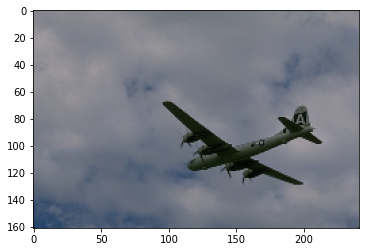

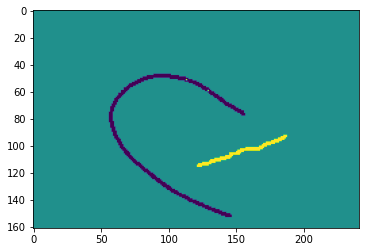


 Segmentation with Lambda = 0.001


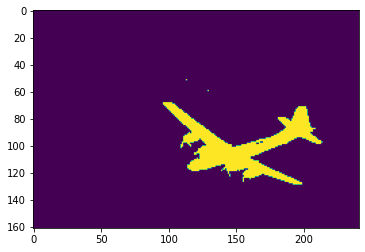


 Segmentation with Lambda = 0.01


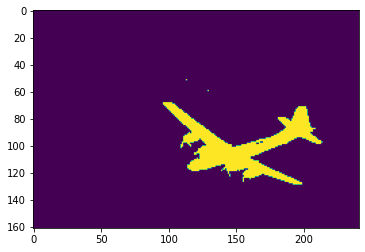


 Segmentation with Lambda = 0.1


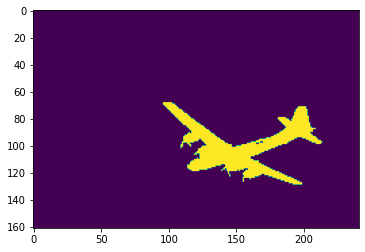


----------------------
Next image: 



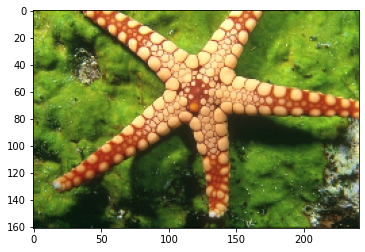

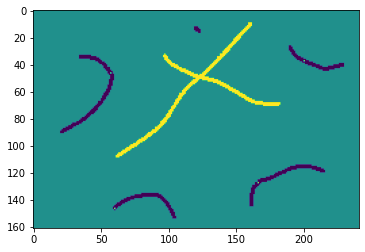


 Segmentation with Lambda = 0.001


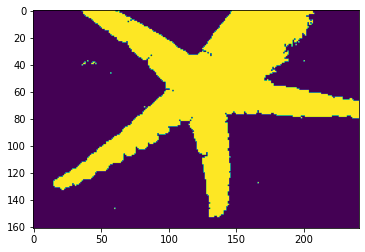


 Segmentation with Lambda = 0.01


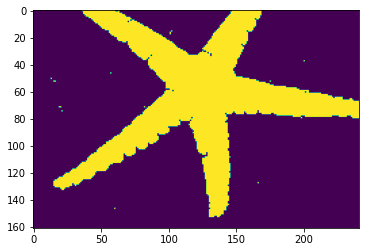


 Segmentation with Lambda = 0.1


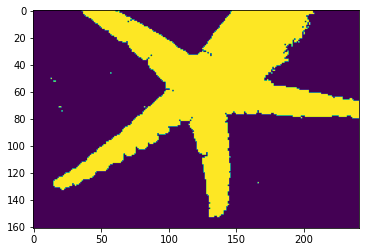


----------------------
Next image: 



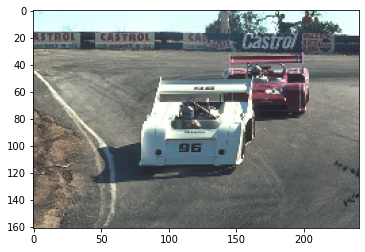

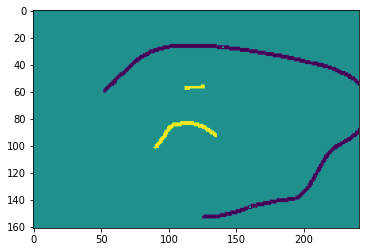


 Segmentation with Lambda = 0.001


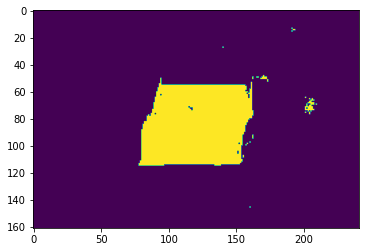


 Segmentation with Lambda = 0.01


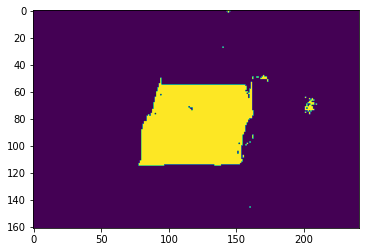


 Segmentation with Lambda = 0.1


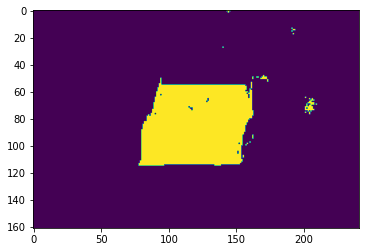


----------------------
Next image: 



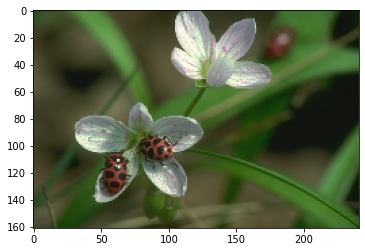

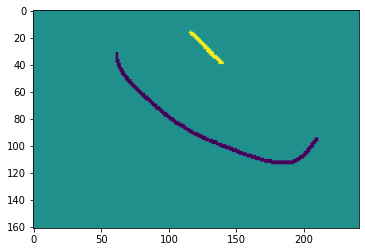


 Segmentation with Lambda = 0.001


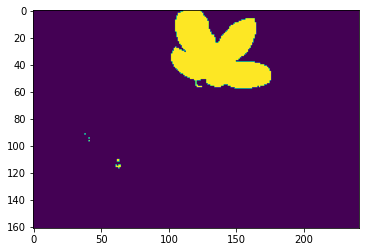


 Segmentation with Lambda = 0.01


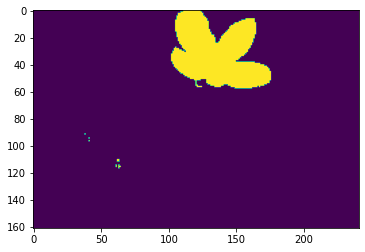


 Segmentation with Lambda = 0.1


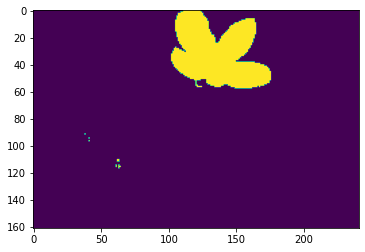


----------------------
Next image: 



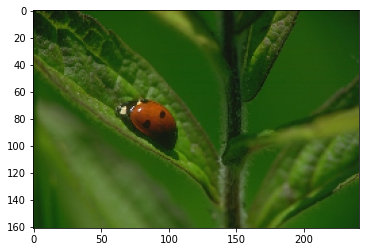

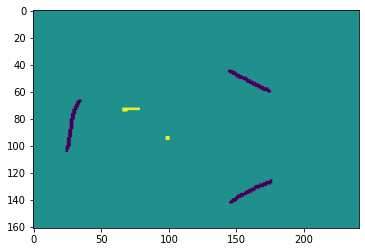


 Segmentation with Lambda = 0.001


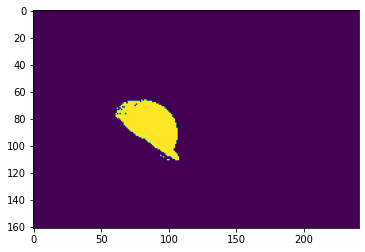


 Segmentation with Lambda = 0.01


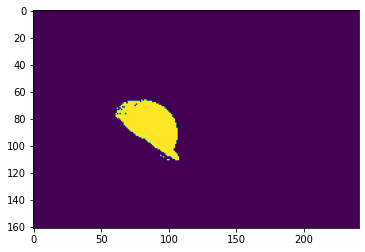


 Segmentation with Lambda = 0.1


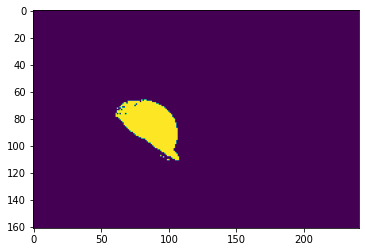

In [4]:
# for each image: plot original image, initial labeling and the resulting segmentation

for i in range(len(X)):
  print("\n----------------------")
  print("Next image: \n")

  W = BuildWeights(X[i], 20, 3, 0.02, 0.01) # compute weights
  plt.imshow(X[i]) # plot original image
  plt.show()
  print("\n")
  plt.imshow(Y[i]) # plot initial labeling
  plt.show()
  for l in [0.001, 0.01, 0.1]: # iterate through different lambdas
    print("\n Segmentation with Lambda =", l)
    f = GetSSLSOlution(W, Y[i], l)
    f_res = np.sign(np.reshape(f, (X[i].shape[0], X[i].shape[1])))
    plt.imshow(f_res) # plot segmentation
    plt.show()

Evaluating different regularization parameters (for the graph construction) on the task of separating the given images into foreground and background, it can be seen that the scale of lambda does not heavily influence the segmentation outcome (perhaps best: lambda = 0.1). 

In general, comparing the performance on the five images, the algorithm is able to reasonably detect foreground and background for all of the five images.


